# Welcome to the QICK lab day 1 at the 2024 QIS Summer School!

### Day 1 agenda:
* Introducing our teaching team and welcoming you to the labs (~30 minutes)
* QubitControl notebook ("Show and Tell" style) (~45 min)
* Resonator notebook (More hands on work for you) (~45 min)

### Day 2 agenda:
* Discussion of superconducting qubit control pulse sequences (especially how to measure qubit T1) (~30 minutes)
* QubitReadout notebook (More hands on work for you) (~90 min)

```diff
+ Throughout both lab days, we will be asking you questions in green font! Please answer them in a new cell below the question.
```

# RF superconducting qubit control 101 - sending pulses to two qubits

### This is a "Show and Tell" style notebook where not many questions will be asked, its more of a warm up notebook. The main concept to understand, which we will be using in the further labs, is the concept of how a signal can be represented in terms of I and Q quadratures.

In [1]:
#pip install cirq

In [2]:
import sys
# sys.path.append('../../qick/qick_lib/')
sys.path.append('../soft/')
sys.path.append('../firmware/')

from qick import *
from qick_training import *
from qick.averager_program import QickSweep
from qick.averager_program import merge_sweeps
from RBSupport import generate_2qgateset

import numpy as np
from numpy.fft import fft, fftshift
import matplotlib.pyplot as plt
import pickle
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import matplotlib.ticker as mtick

In [3]:
soc = QickSoc()
soccfg = soc

print(soccfg)

QICK running on RFSoC4x2, software version 0.2.272

Firmware configuration (built Wed Sep  6 18:49:29 2023):

	Global clocks (MHz): tProcessor 409.600, RF reference 491.520

	2 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (6.667 us)
		fs=9830.400 MHz, fabric=614.400 MHz, 32-bit DDS, range=9830.400 MHz
		DAC tile 0, blk 0 is DAC_B
	1:	axis_signal_gen_v6 - envelope memory 65536 samples (6.667 us)
		fs=9830.400 MHz, fabric=614.400 MHz, 32-bit DDS, range=9830.400 MHz
		DAC tile 2, blk 0 is DAC_A

	2 readout channels:
	0:	axis_readout_v2 - configured by PYNQ
		fs=4423.680 MHz, decimated=552.960 MHz, 32-bit DDS, range=4423.680 MHz
		maxlen 16384 accumulated, 1024 decimated (1.852 us)
		triggered by output 7, pin 14, feedback to tProc input 0
		ADC tile 0, blk 0 is ADC_D
	1:	axis_readout_v2 - configured by PYNQ
		fs=4423.680 MHz, decimated=552.960 MHz, 32-bit DDS, range=4423.680 MHz
		maxlen 16384 accumulated, 1024 decimated (1.852 us)
		triggered by outpu

In [4]:
class PulseSequence(AveragerProgram):
    def initialize_phases(self):
        ## Prepare state
        self.phase_ref_q1 = 0
        self.phase_ref_q2 = 0
        self.phase_ref_c = 0
    
    def play_seq(self, seq):
        for g in seq:
            for q in g:
                if q == "Q2":
                    ginfo=self.cfg["gate_set"][g[q]]
                    if g[q]=="Z":
                        self.phase_ref_q2+=180
                    elif g[q]=="Z/2":
                        self.phase_ref_q2+=90
                    elif g[q]=="-Z/2":
                        self.phase_ref_q2+=-90
                    else:
                        self.set_pulse_registers(ch=self.cfg["q2_ch"], freq=self.freq_q2,
                                                 phase=self.deg2reg(self.phase_ref_q2 + ginfo["phase"], gen_ch=self.cfg["q2_ch"]),
                                                 gain=ginfo["gain"], waveform=g[q], phrst=0,mode="oneshot")
                        self.pulse(ch=self.cfg["q2_ch"])
                if q == "Q1": # Qubit 1
                    ginfo=self.cfg["gate_set"][g[q]]
                    """For the Z gates (virtual rotation), we need to advance the phase of all the pulses which follows afterwards"""
                    if g[q]=="Z":
                        self.phase_ref_q1+=180
                    elif g[q]=="Z/2":
                        self.phase_ref_q1+=90
                    elif g[q]=="-Z/2":
                        self.phase_ref_q1+=-90
                    else:
                        self.set_pulse_registers(ch=self.cfg["q1_ch"], freq=self.freq_q1,
                                                 phase=self.deg2reg(self.phase_ref_q1 + ginfo["phase"], gen_ch=self.cfg["q1_ch"]),
                                                 gain=ginfo["gain"], waveform=g[q], phrst=0,mode="oneshot")
                        self.pulse(ch=self.cfg["q1_ch"])
            ################
           #modified sync_all with only DAC clocks, no ADC clocks
            self.synci(self.us2cycles(0.01))
    
    def initialize(self):
        cfg = self.cfg
        self.gate_seq = cfg['gate_seq']
        self.gate_set = cfg['gate_set']
        # set the nyquist zone
        self.declare_gen(ch=cfg["q1_ch"], nqz=1)
        self.declare_gen(ch=cfg["q2_ch"], nqz=1)

        for ch in cfg["ro_chs"]:
            self.declare_readout(ch=ch, length=cfg["readout_length"],
                                 freq=cfg["q" + str(ch + 1) +"_read_freq"], 
                                 gen_ch=cfg["q" + str(ch + 1) +"_ch"])
            
        # convert frequency to DAC frequency (ensuring it is an available ADC frequency)
        self.freq_q1 = self.freq2reg(cfg["q1_pulse_freq"], gen_ch=cfg["q1_ch"], ro_ch=cfg["q1_ro_ch"])
        self.freq_q2 = self.freq2reg(cfg["q2_pulse_freq"], gen_ch=cfg["q2_ch"], ro_ch=cfg["q2_ro_ch"])

        for name, ginfo in self.gate_set.items():
            self.add_pulse(ch=cfg["q1_ch"], name=name,
                           idata=ginfo["idata"],
                           qdata=ginfo["qdata"],
                          )
            self.add_pulse(ch=cfg["q2_ch"], name=name,
                           idata=ginfo["idata"],
                           qdata=ginfo["qdata"],
                          )

        self.default_pulse_registers(ch=cfg["q1_ch"], style="arb")
        self.default_pulse_registers(ch=cfg["q2_ch"], style="arb")

        self.synci(1000)  # give processor some time to configure pulses

    def body(self):
        ## Trigger measurement
        self.trigger(adcs=self.ro_chs,
                     pins=[0],
                     adc_trig_offset=self.cfg["adc_trig_offset"])

        self.initialize_phases()
        self.play_seq(self.gate_seq)
        self.wait_all()
        self.sync_all(self.us2cycles(self.cfg["relax_delay"]))

In [5]:
# Plot function

def plot_2q(iq_lists):
    for n in range(0, len(iq_lists)):
        fig, axs = plt.subplots(len(iq_lists[n]),dpi=200)
        for ii, iq in enumerate(iq_lists[n]):
            axs[ii].set_title("Qubit %d" % (config['ro_chs'][ii]+1))
            axs[ii].plot(1000*soc.cycles2us(np.arange(0,len(iq[0])),ro_ch=config['ro_chs'][ii]
                                                                ),iq[0], label="I value, ADC %d" % (config['ro_chs'][ii]))
            axs[ii].plot(1000*soc.cycles2us(np.arange(0,len(iq[0])),ro_ch=config['ro_chs'][ii]
                                                                ),iq[1], label="Q value, ADC %d" % (config['ro_chs'][ii]))
            axs[ii].plot(1000*soc.cycles2us(np.arange(0,len(iq[0])),ro_ch=config['ro_chs'][ii]
                                                                ),np.abs(iq[0] + 1j * iq[1]), label="mag, ADC %d" % (config['ro_chs'][ii]))
            axs[ii].legend(loc=1, prop={'size': 6})
            axs[ii].set_ylabel("a.u.")
            axs[ii].xaxis.set_major_locator(MultipleLocator(1000*5*soc.cycles2us(4, gen_ch = 0)))
            axs[ii].grid(which='major', color='#CCCCCC', linestyle='--')
            axs[ii].xaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
            axs[ii].tick_params(axis='x', rotation=45)

        plt.xlabel('ns')
        plt.tight_layout()

# RF superconducting qubit control 101: Let's get started!

## Qubits are resonant devices

Qubits are resonant devices: they only respond to on-resonance signals, but avoid exciting other transitions.

Let's drive our qubits with three 2 GHz "X" pi pulses in a row. Since we are also reading in at 2 GHz, we see a fully downconverted "DC" signal.

In [6]:
q1_pulse_freq = 2000 
q1_read_freq = 2000
q2_pulse_freq = 2000 
q2_read_freq = 2000

config = {"q1_ch": 0,  # --Fixed
          "q2_ch": 1,
          "q1_ro_ch": 0,
          "q2_ro_ch": 1,
          "ro_chs": [0,1],
          "reps": 1,  # --Fixed
          "relax_delay": 1.0,  # --us
          "res_phase": 0,  # --degrees
          "pulse_style": "arb",  # --Fixed
          "pi_sigma": soc.us2cycles(0.01,gen_ch=0),
          "readout_length": soc.us2cycles(1,ro_ch=0),  # [Clock ticks]
          "pi_gain": 30000,  # [DAC units]
          "pi_2_gain": 15000,
          "q1_pulse_freq": q1_pulse_freq,  # [MHz]
          "q2_pulse_freq": q2_pulse_freq,  # [MHz]
          "q1_read_freq": q1_read_freq,
          "q2_read_freq": q2_read_freq,
          "adc_trig_offset": soc.us2cycles(0.2,ro_ch=0),  # [Clock ticks] # 0.1 wokred
          "soft_avgs": 1,
          "expts": 1
          }

config["gate_set"] = generate_2qgateset(config)

config['gate_seq'] = [{'Q1': 'X', 'Q2': 'X'}, {'Q1': 'X', 'Q2': 'X'}, {'Q1': 'X', 'Q2': 'X'} ]

print(config['gate_seq'])

[{'Q1': 'X', 'Q2': 'X'}, {'Q1': 'X', 'Q2': 'X'}, {'Q1': 'X', 'Q2': 'X'}]


In [7]:
prog = PulseSequence(soccfg, config)
# print(prog)
iq_lists = []
# print(self.cfg)
soc.reset_gens()  # clear any DC or periodic values on generators
iq_list = prog.acquire_decimated(soc, load_pulses=True, progress=False)
iq_lists.append(iq_list)

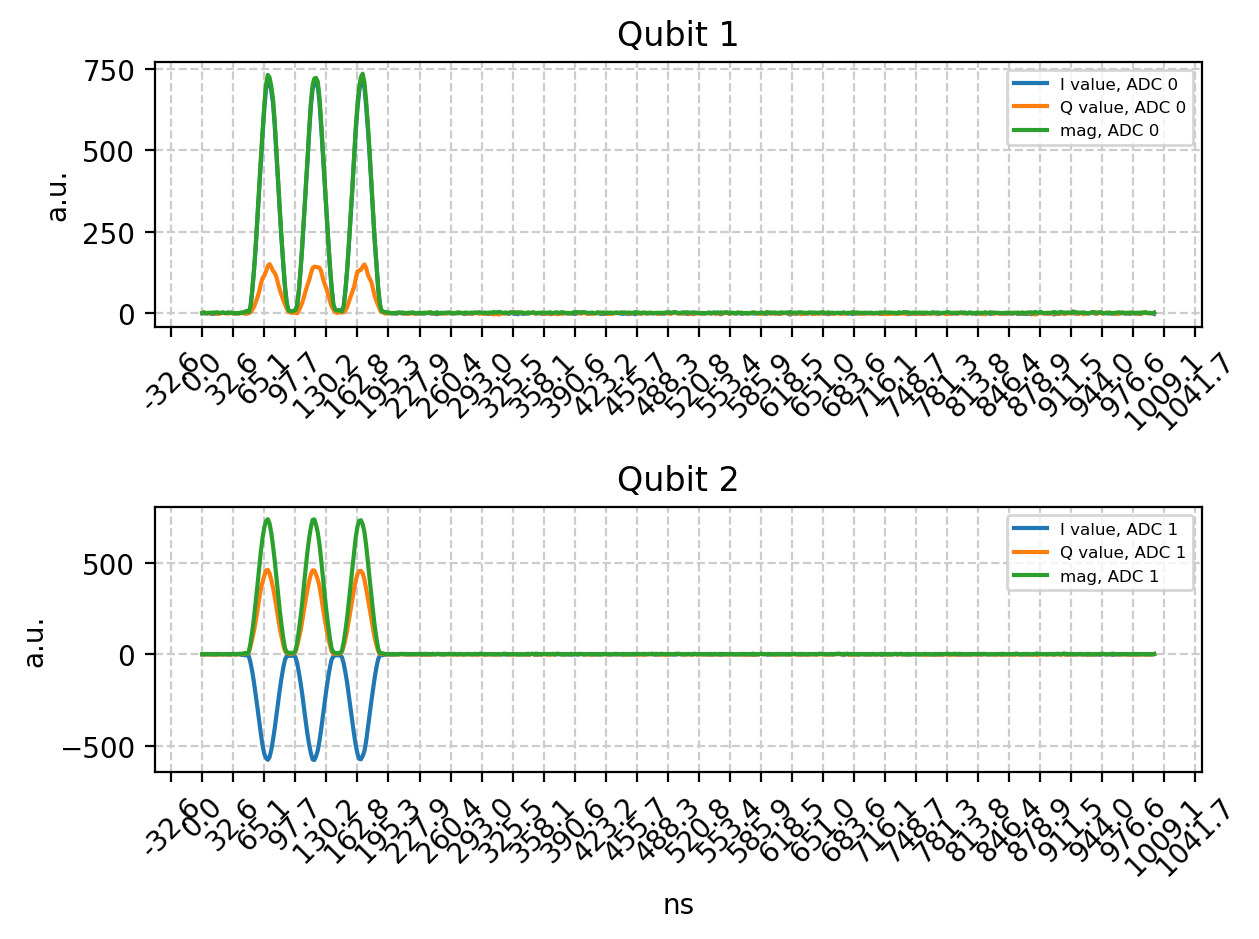

In [8]:
plot_2q(iq_lists)

Let's try reading in at a different frequency. When we do this, we don't "downconvert" the signal fully and end up seeing frequency components in I/Q space. The signal has the same magnitude though. We DON'T want to do this with real qubits as we want to see the undistorted signals in I/Q space. We will talk about this in a later notebook QubitReadout.


In [9]:
q1_pulse_freq = 2000 
q1_read_freq = 1800
q2_pulse_freq = 2000 
q2_read_freq = 1800

config = {"q1_ch": 0,  # --Fixed
          "q2_ch": 1,
          "q1_ro_ch": 0,
          "q2_ro_ch": 1,
          "ro_chs": [0,1],
          "reps": 1,  # --Fixed
          "relax_delay": 1.0,  # --us
          "res_phase": 0,  # --degrees
          "pulse_style": "arb",  # --Fixed
          "pi_sigma": soc.us2cycles(0.01,gen_ch=0),
          "readout_length": soc.us2cycles(1,ro_ch=0),  # [Clock ticks]
          "pi_gain": 30000,  # [DAC units]
          "pi_2_gain": 15000,
          "q1_pulse_freq": q1_pulse_freq,  # [MHz]
          "q2_pulse_freq": q2_pulse_freq,  # [MHz]
          "q1_read_freq": q1_read_freq,
          "q2_read_freq": q2_read_freq,
          "adc_trig_offset": soc.us2cycles(0.2,ro_ch=0),  # [Clock ticks] # 0.1 wokred
          "soft_avgs": 1,
          "expts": 1
          }


config["gate_set"] = generate_2qgateset(config)

config['gate_seq'] = [{'Q1': 'X', 'Q2': 'X'}, {'Q1': 'X', 'Q2': 'X'}, {'Q1': 'X', 'Q2': 'X'} ]

print(config['gate_seq']) 

[{'Q1': 'X', 'Q2': 'X'}, {'Q1': 'X', 'Q2': 'X'}, {'Q1': 'X', 'Q2': 'X'}]


In [10]:
prog = PulseSequence(soccfg, config)
# print(prog)
iq_lists = []
# print(self.cfg)
soc.reset_gens()  # clear any DC or periodic values on generators
iq_list = prog.acquire_decimated(soc, load_pulses=True, progress=False)
iq_lists.append(iq_list)

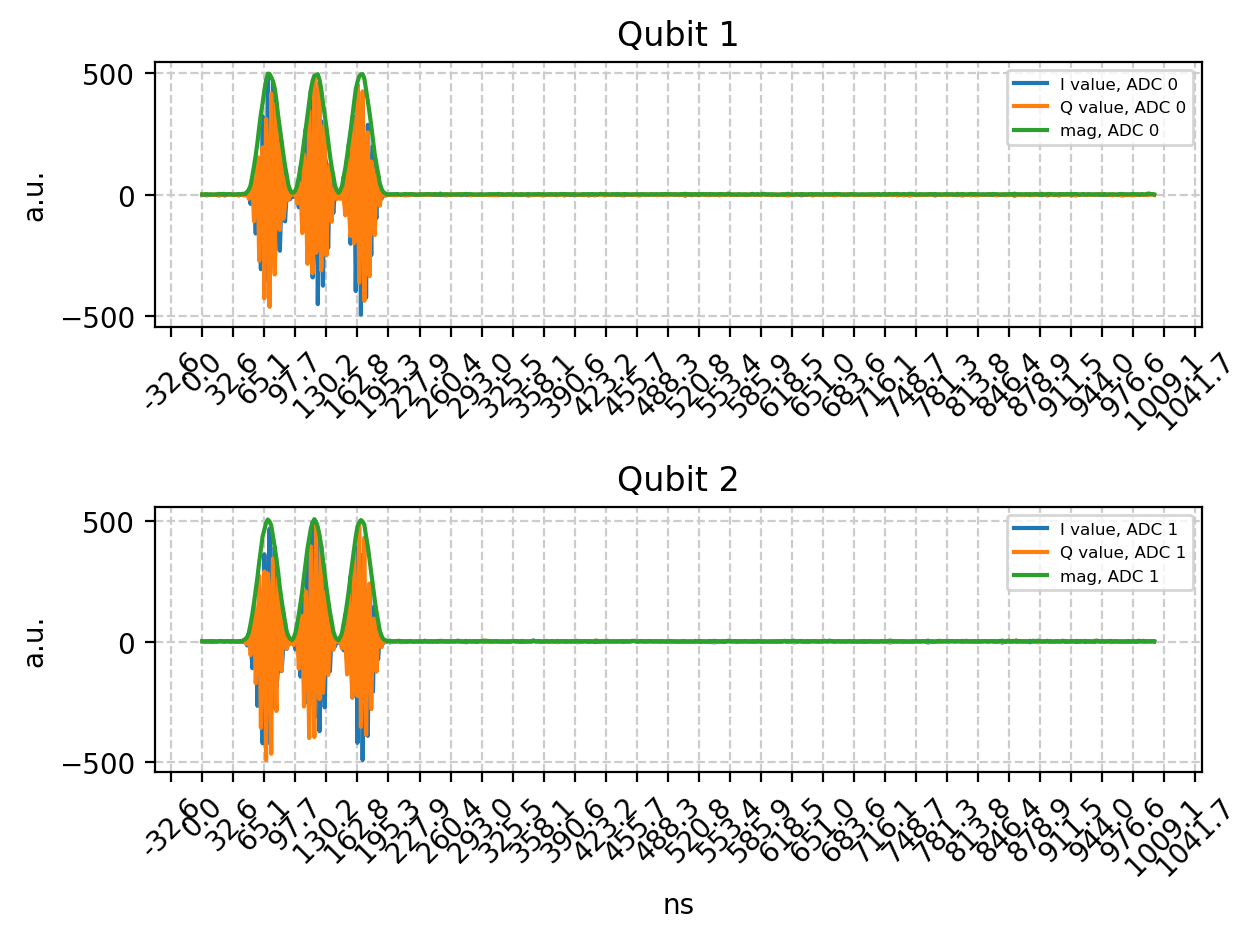

In [11]:
plot_2q(iq_lists)

```diff
+ Q: Why in the first measurement did you see a clear Gaussian, and in this measurement you see a sine wave with a Gaussian envelope?
```

In general, the qubits are at different frequencies. 

In [12]:
q1_pulse_freq = 2000 
q1_read_freq = 2000
q2_pulse_freq = 1800
q2_read_freq = 1800

config = {"q1_ch": 0,  # --Fixed
          "q2_ch": 1,
          "q1_ro_ch": 0,
          "q2_ro_ch": 1,
          "ro_chs": [0,1],
          "reps": 1,  # --Fixed
          "relax_delay": 1.0,  # --us
          "res_phase": 0,  # --degrees
          "pulse_style": "arb",  # --Fixed
          "pi_sigma": soc.us2cycles(0.01,gen_ch=0),
          "readout_length": soc.us2cycles(1,ro_ch=0),  # [Clock ticks]
          "pi_gain": 30000,  # [DAC units]
          "pi_2_gain": 15000,
          "q1_pulse_freq": q1_pulse_freq,  # [MHz]
          "q2_pulse_freq": q2_pulse_freq,  # [MHz]
          "q1_read_freq": q1_read_freq,
          "q2_read_freq": q2_read_freq,
          "adc_trig_offset": soc.us2cycles(0.2,ro_ch=0),  # [Clock ticks] # 0.1 wokred
          "soft_avgs": 1,
          "expts": 1
          }

config["gate_set"] = generate_2qgateset(config)

config['gate_seq'] = [{'Q1': 'X', 'Q2': 'X'}, {'Q1': 'X', 'Q2': 'X'}, {'Q1': 'X', 'Q2': 'X'} ]

print(config['gate_seq']) 

[{'Q1': 'X', 'Q2': 'X'}, {'Q1': 'X', 'Q2': 'X'}, {'Q1': 'X', 'Q2': 'X'}]


In [13]:
prog = PulseSequence(soccfg, config)
# print(prog)
iq_lists = []
# print(self.cfg)
soc.reset_gens()  # clear any DC or periodic values on generators
iq_list = prog.acquire_decimated(soc, load_pulses=True, progress=False)
iq_lists.append(iq_list)

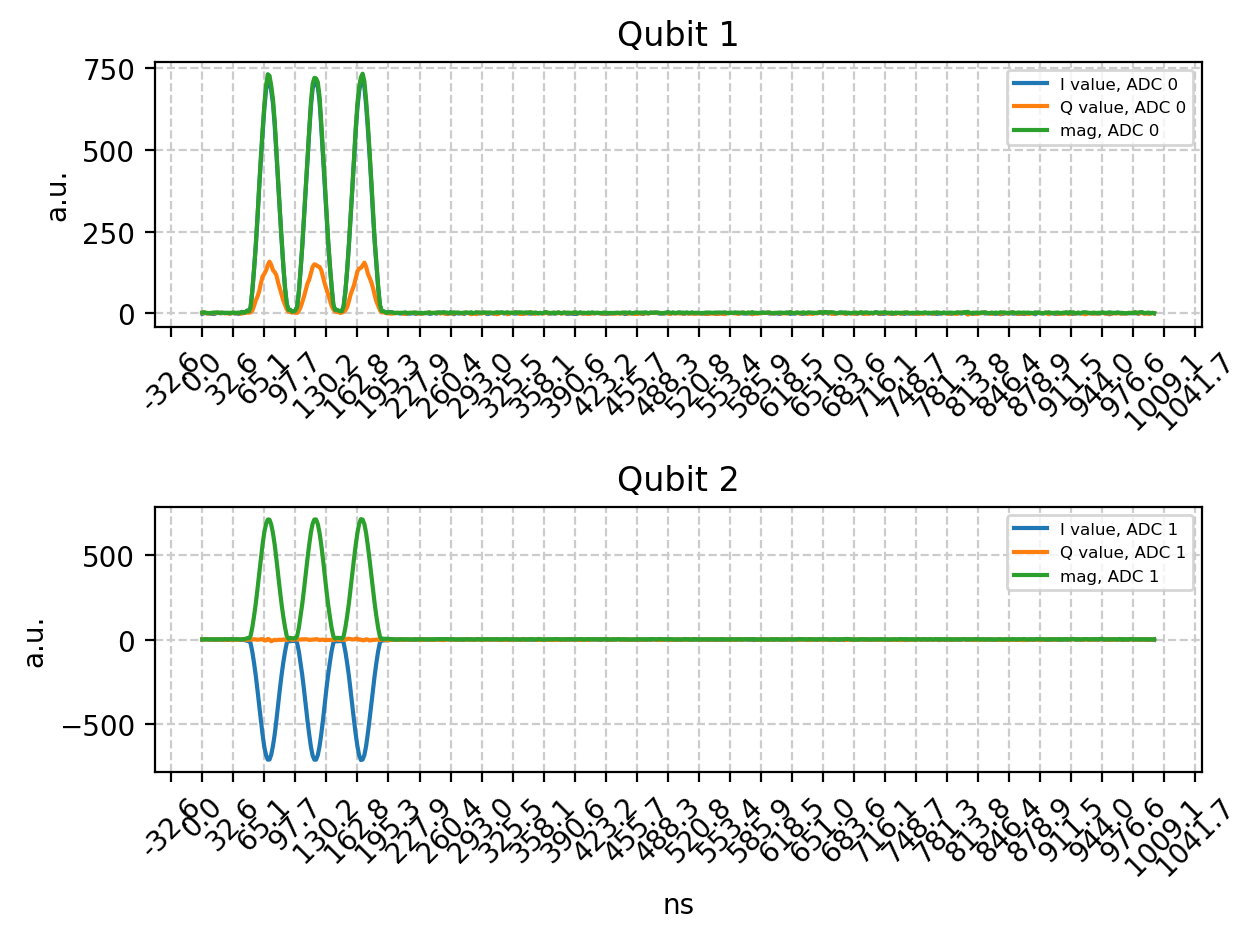

In [14]:
plot_2q(iq_lists)

## Quantum gates are Gaussian wave packets at the resonant frequency

Quantum gates are wave packets at the resonant frequency; you want an envelope that minimizes duration and bandwidth, so the envelope should be Gaussian, not rectangular.

Let's change the width of our Gaussian envelope that we use to drive our qubits.
Our original width is 0.01 us. Let's change that to 0.05 us!


In [15]:
q1_pulse_freq = 2000 
q1_read_freq = 2000
q2_pulse_freq = 1800 
q2_read_freq = 1800
pi_sigma_us = 0.05

config = {"q1_ch": 0,  # --Fixed
          "q2_ch": 1,
          "q1_ro_ch": 0,
          "q2_ro_ch": 1,
          "ro_chs": [0,1],
          "reps": 1,  # --Fixed
          "relax_delay": 1.0,  # --us
          "res_phase": 0,  # --degrees
          "pulse_style": "arb",  # --Fixed
          "pi_sigma": soc.us2cycles(pi_sigma_us,gen_ch=0),
          "readout_length": soc.us2cycles(1,ro_ch=0),  # [Clock ticks]
          "pi_gain": 30000,  # [DAC units]
          "pi_2_gain": 15000,
          "q1_pulse_freq": q1_pulse_freq,  # [MHz]
          "q2_pulse_freq": q2_pulse_freq,  # [MHz]
          "q1_read_freq": q1_read_freq,
          "q2_read_freq": q2_read_freq,
          "adc_trig_offset": soc.us2cycles(0.2,ro_ch=0),  # [Clock ticks] # 0.1 wokred
          "soft_avgs": 1,
          "expts": 1
          }


config["gate_set"] = generate_2qgateset(config)

config['gate_seq'] = [{'Q1': 'X', 'Q2': 'X'}, {'Q1': 'X', 'Q2': 'X'}, {'Q1': 'X', 'Q2': 'X'} ]

print(config['gate_seq'])

[{'Q1': 'X', 'Q2': 'X'}, {'Q1': 'X', 'Q2': 'X'}, {'Q1': 'X', 'Q2': 'X'}]


In [16]:
prog = PulseSequence(soccfg, config)
# print(prog)
iq_lists = []
# print(self.cfg)
soc.reset_gens()  # clear any DC or periodic values on generators
iq_list = prog.acquire_decimated(soc, load_pulses=True, progress=False)
iq_lists.append(iq_list)

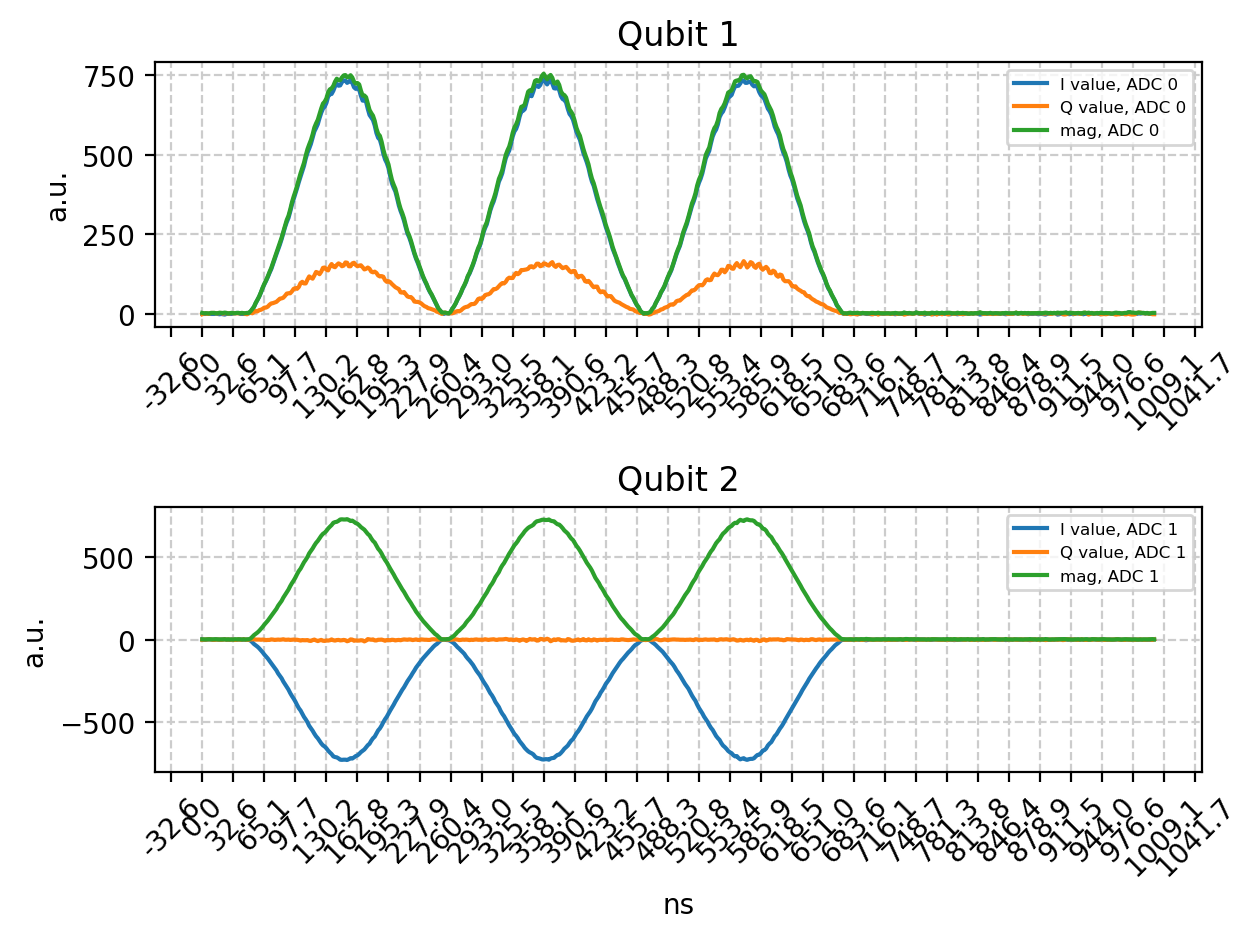

In [17]:
plot_2q(iq_lists)

```diff
+ Q: Why do you think qubit control pulses are typically Gaussian but readout pulses are typically square?
```

## The qubit drive pulse phase sets the axis of rotation on the Bloch sphere.

* A X pulse rotates the qubit 180 degrees about the X axis of its Bloch sphere.
* A Y pulse rotates the qubit 180 degrees about the Y axis of its Bloch sphere.
* See and play around with this using the Quirk circuit simulator here: https://algassert.com/quirk#circuit={%22cols%22:[[%22Y^%C2%BD%22,%22X^%C2%BD%22]]} In this setup, Qubit 1 had a Y/2 gate applied while Qubit 2 had a X/2 gate applied.


Lets change the gate sequence to match the Quirk simulation (Y/2,X/2) on the two qubits, and then make the 2nd pulse be (Y,X) on the two qubits, and then finally do a 3rd pulse of (X,X) on the two qubits.

Notice how the phase of qubit 1 flips between I and Q when it goes from Y to X (the 2nd pulse to the 3rd pulse).

In [18]:
q1_pulse_freq = 2000 
q1_read_freq = 2000
q2_pulse_freq = 1800 
q2_read_freq = 1800
pi_sigma_us = 0.05

config = {"q1_ch": 0,  # --Fixed
          "q2_ch": 1,
          "q1_ro_ch": 0,
          "q2_ro_ch": 1,
          "ro_chs": [0,1],
          "reps": 1,  # --Fixed
          "relax_delay": 1.0,  # --us
          "res_phase": 0,  # --degrees
          "pulse_style": "arb",  # --Fixed
          "pi_sigma": soc.us2cycles(pi_sigma_us,gen_ch=0),
          "readout_length": soc.us2cycles(1,ro_ch=0),  # [Clock ticks]
          "pi_gain": 30000,  # [DAC units]
          "pi_2_gain": 15000,
          "q1_pulse_freq": q1_pulse_freq,  # [MHz]
          "q2_pulse_freq": q2_pulse_freq,  # [MHz]
          "q1_read_freq": q1_read_freq,
          "q2_read_freq": q2_read_freq,
          "adc_trig_offset": soc.us2cycles(0.2,ro_ch=0),  # [Clock ticks] # 0.1 wokred
          "soft_avgs": 1,
          "expts": 1
          }

config["gate_set"] = generate_2qgateset(config)

### We change this!
config['gate_seq'] = [{'Q1': 'Y/2', 'Q2': 'X/2'}, {'Q1': 'Y', 'Q2': 'X'}, {'Q1': 'X', 'Q2': 'X'} ]

print(config['gate_seq'])

[{'Q1': 'Y/2', 'Q2': 'X/2'}, {'Q1': 'Y', 'Q2': 'X'}, {'Q1': 'X', 'Q2': 'X'}]


In [19]:
prog = PulseSequence(soccfg, config)
# print(prog)
iq_lists = []
# print(self.cfg)
soc.reset_gens()  # clear any DC or periodic values on generators
iq_list = prog.acquire_decimated(soc, load_pulses=True, progress=False)
iq_lists.append(iq_list)

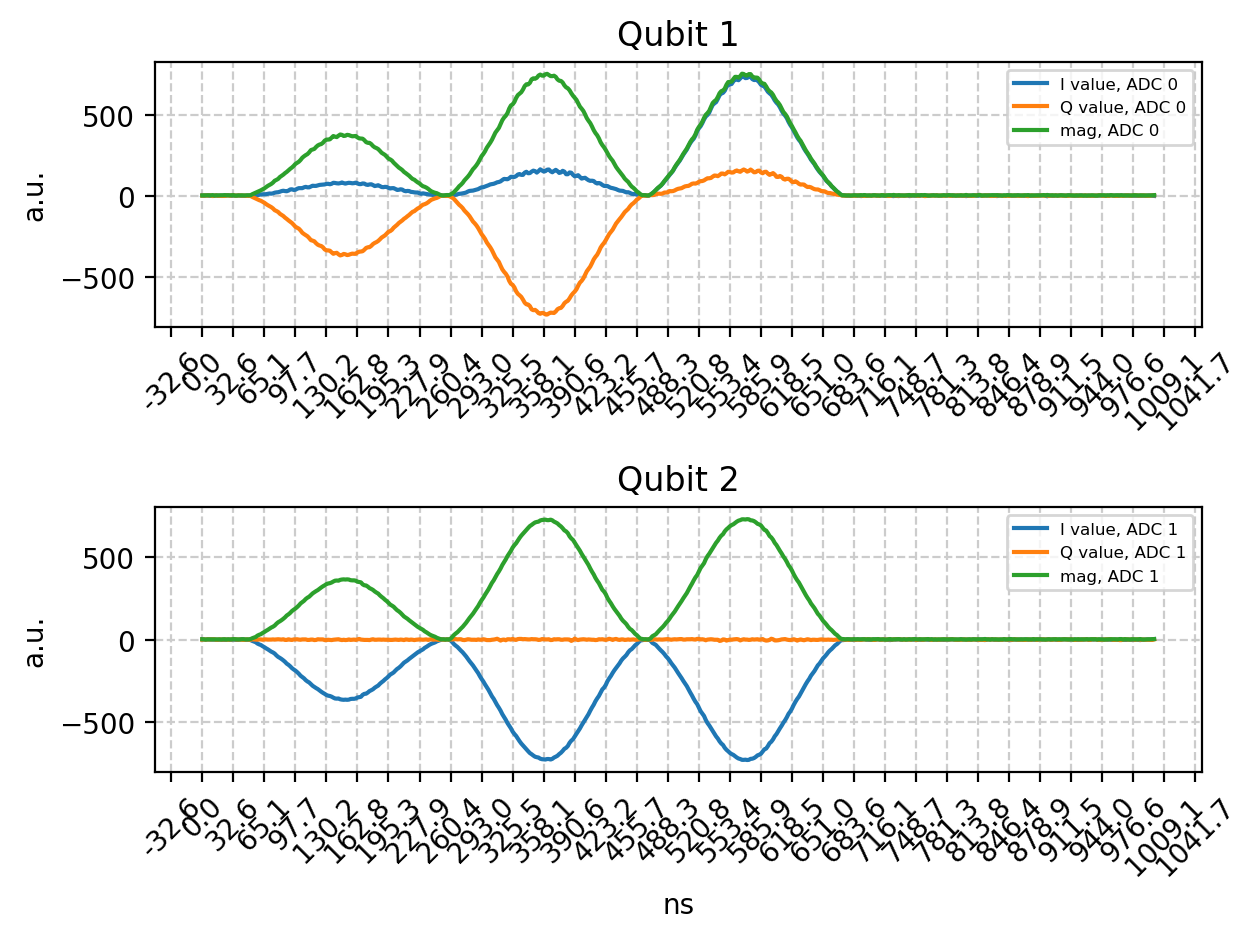

In [20]:
plot_2q(iq_lists)

## The qubit drive pulse amplitude sets the angular velocity on the Bloch sphere. How much will the qubit rotate on the Bloch sphere during the pulse?

A X/2 (or Y/2) gate it will rotate the qubit by 90 degrees around its Bloch sphere. A X (or Y) gate will rotate the qubit by 180 degrees around its Bloch sphere.

Lets change the gate sequence to do some X and X/2, Y and Y/2 gates on the qubits. 

See the Quirk circuit equivalent https://algassert.com/quirk#circuit={%22cols%22:[[%22Y^%C2%BD%22,%22X^%C2%BD%22],[%22Y%22,%22X%22],[%22X%22,%22X%22],[%22Y^-%C2%BD%22,%22X^%C2%BD%22],[1,%22X^%C2%BD%22],[%22X%22,%22X^-%C2%BD%22]]} to see where the qubits end up on the Bloch sphere! 

Notice the difference between a Y/2 and -Y/2 (or X/2 and -X/2) gate. Notice what the I gate does (nothing! Its is represented by the identity matrix).

In [21]:
q1_pulse_freq = 2000 
q1_read_freq = 2000
q2_pulse_freq = 1800 
q2_read_freq = 1800
pi_sigma_us = 0.03

config = {"q1_ch": 0,  # --Fixed
          "q2_ch": 1,
          "q1_ro_ch": 0,
          "q2_ro_ch": 1,
          "ro_chs": [0,1],
          "reps": 1,  # --Fixed
          "relax_delay": 1.0,  # --us
          "res_phase": 0,  # --degrees
          "pulse_style": "arb",  # --Fixed
          "pi_sigma": soc.us2cycles(pi_sigma_us,gen_ch=0),
          "readout_length": soc.us2cycles(1,ro_ch=0),  # [Clock ticks]
          "pi_gain": 30000,  # [DAC units]
          "pi_2_gain": 15000,
          "q1_pulse_freq": q1_pulse_freq,  # [MHz]
          "q2_pulse_freq": q2_pulse_freq,  # [MHz]
          "q1_read_freq": q1_read_freq,
          "q2_read_freq": q2_read_freq,
          "adc_trig_offset": soc.us2cycles(0.2,ro_ch=0),  # [Clock ticks] # 0.1 wokred
          "soft_avgs": 1,
          "expts": 1
          }

config["gate_set"] = generate_2qgateset(config)

### We change this!
config['gate_seq'] = [{'Q1': 'Y/2', 'Q2': 'X/2'}, {'Q1': 'Y', 'Q2': 'X'},
                      {'Q1': 'X', 'Q2': 'X'}, {'Q1': '-Y/2', 'Q2': 'X/2'},
                      {'Q1': 'I', 'Q2': 'X/2'},{'Q1': 'X', 'Q2': '-X/2'}]

print(config['gate_seq'])

[{'Q1': 'Y/2', 'Q2': 'X/2'}, {'Q1': 'Y', 'Q2': 'X'}, {'Q1': 'X', 'Q2': 'X'}, {'Q1': '-Y/2', 'Q2': 'X/2'}, {'Q1': 'I', 'Q2': 'X/2'}, {'Q1': 'X', 'Q2': '-X/2'}]


In [22]:
prog = PulseSequence(soccfg, config)
# print(prog)
iq_lists = []
# print(self.cfg)
soc.reset_gens()  # clear any DC or periodic values on generators
iq_list = prog.acquire_decimated(soc, load_pulses=True, progress=False)
iq_lists.append(iq_list)

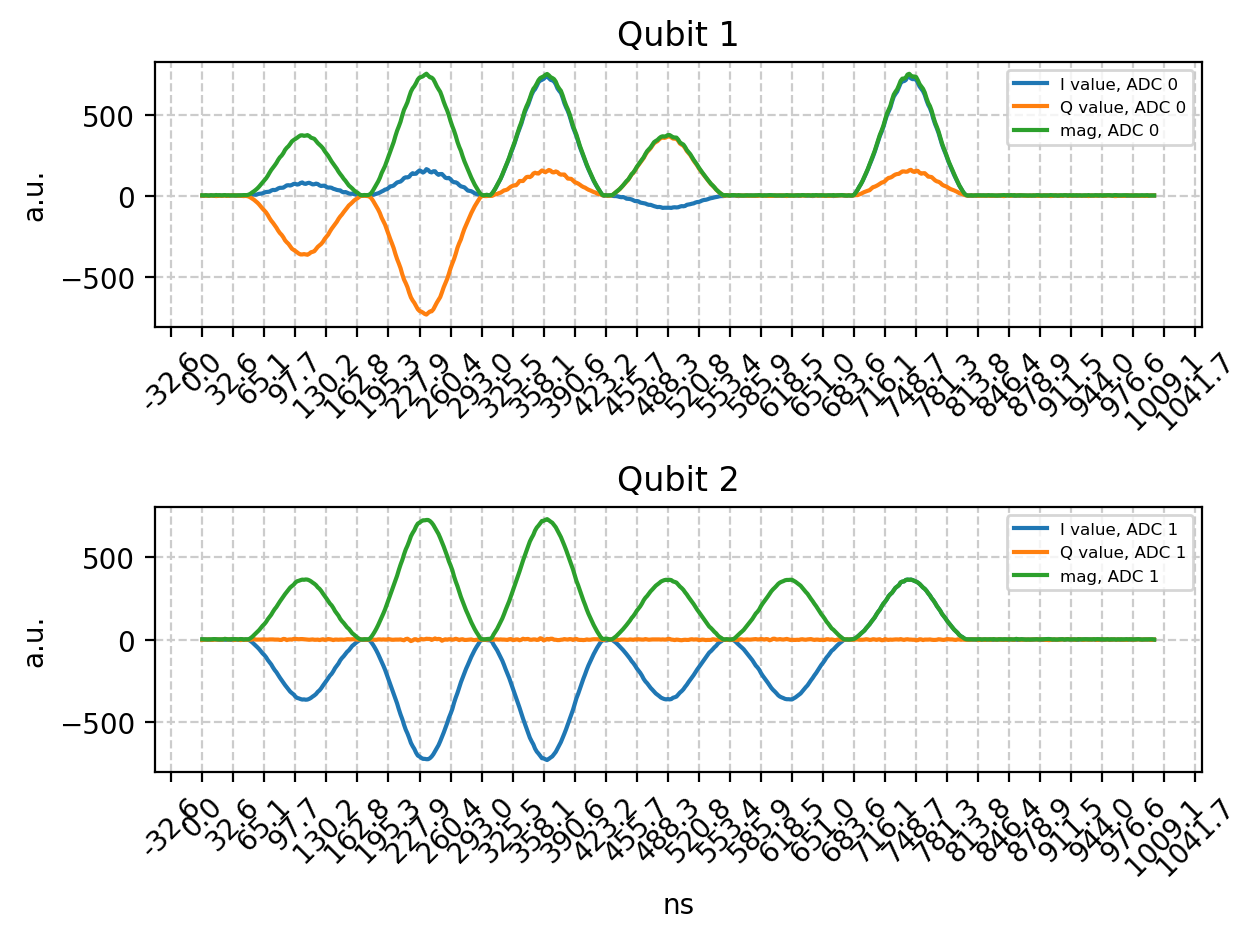

In [23]:
plot_2q(iq_lists)

## Multiple X gates and virtual-Z gates

If you have multiple X gates, they all need to match the qubit’s reference phase (phase coherence); you need to track the reference phase to define your X, Y, virtual-Z

For the Z gates (virtual rotation), we need to advance the phase of all the pulses which follow afterwards.

Notice what happens when we applied virtual-Z gates in this example!

In [24]:
q1_pulse_freq = 2000 
q1_read_freq = 2000
q2_pulse_freq = 1800 
q2_read_freq = 1800
pi_sigma_us = 0.03

config = {"q1_ch": 0,  # --Fixed
          "q2_ch": 1,
          "q1_ro_ch": 0,
          "q2_ro_ch": 1,
          "ro_chs": [0,1],
          "reps": 1,  # --Fixed
          "relax_delay": 1.0,  # --us
          "res_phase": 0,  # --degrees
          "pulse_style": "arb",  # --Fixed
          "pi_sigma": soc.us2cycles(pi_sigma_us,gen_ch=0),
          "readout_length": soc.us2cycles(1,ro_ch=0),  # [Clock ticks]
          "pi_gain": 30000,  # [DAC units]
          "pi_2_gain": 15000,
          "q1_pulse_freq": q1_pulse_freq,  # [MHz]
          "q2_pulse_freq": q2_pulse_freq,  # [MHz]
          "q1_read_freq": q1_read_freq,
          "q2_read_freq": q2_read_freq,
          "adc_trig_offset": soc.us2cycles(0.2,ro_ch=0),  # [Clock ticks] # 0.1 wokred
          "soft_avgs": 1,
          "expts": 1
          }

config["gate_set"] = generate_2qgateset(config)

### We change this!
config['gate_seq'] = [{'Q1': 'X', 'Q2': 'X'}, {'Q1': 'Z', 'Q2': 'Z'},
                      {'Q1': 'X', 'Q2': 'X'}]

print(config['gate_seq'])

[{'Q1': 'X', 'Q2': 'X'}, {'Q1': 'Z', 'Q2': 'Z'}, {'Q1': 'X', 'Q2': 'X'}]


In [25]:
prog = PulseSequence(soccfg, config)
# print(prog)
iq_lists = []
# print(self.cfg)
soc.reset_gens()  # clear any DC or periodic values on generators
iq_list = prog.acquire_decimated(soc, load_pulses=True, progress=False)
iq_lists.append(iq_list)

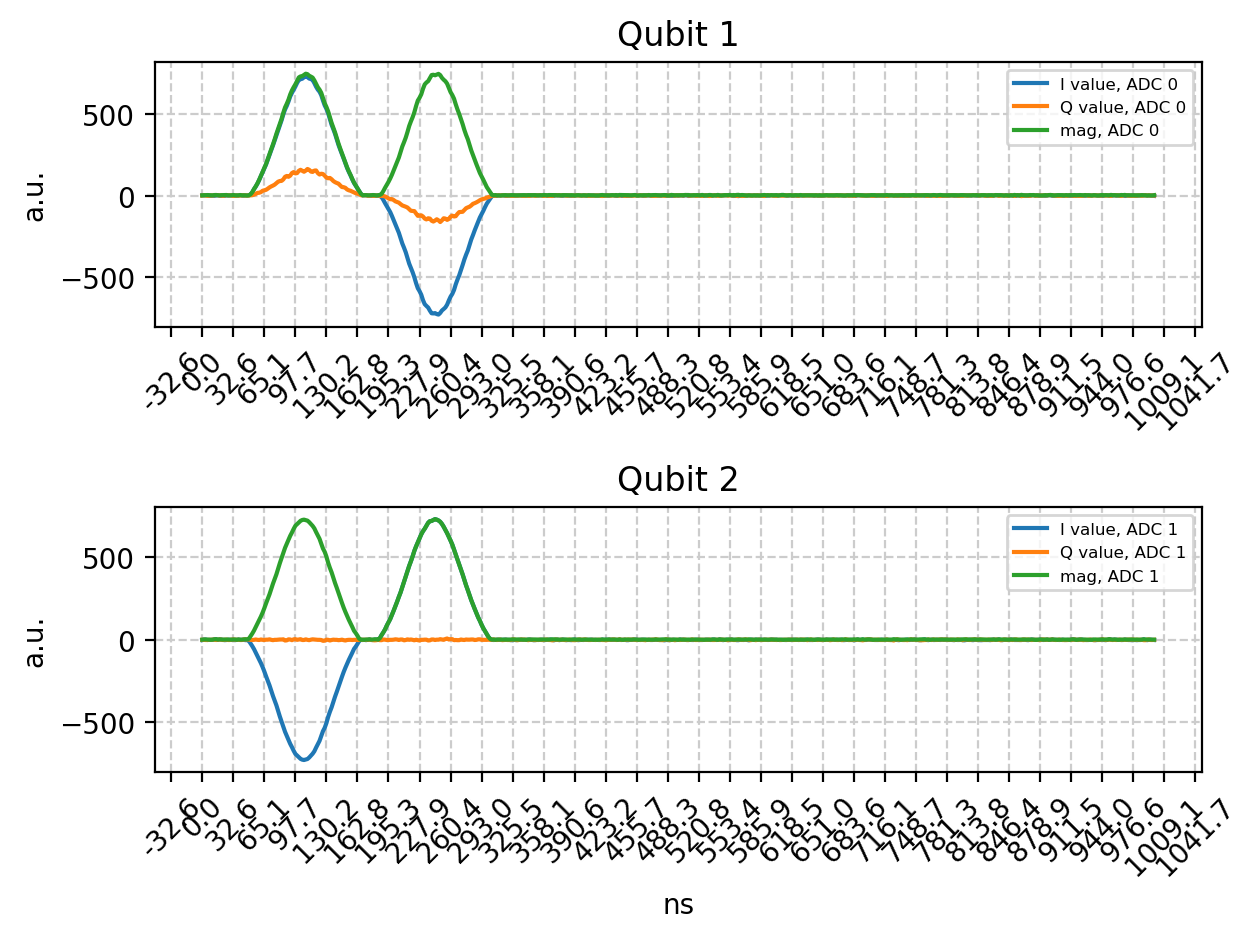

In [26]:
plot_2q(iq_lists)

# ~ Bonus topics for your interest ~

These examples are a little more advanced, and will not be discussed in the labs that follow, they are just included here for your interest.

## Quantum state characterization and qubit gate benchmarking

In general you want to do long pulse sequences for quantum state characterization and qubit gate benchmarking experiments, like in this paper, where 2 qubit randomized benchmarking and 2 qubit state and process tomography was done with the QICK: https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.5.020326

We are loading the gate sequence from a pickle file this time, where it has been stored ahead of time. The gates are the 16 preparation basis gates for two-qubit process tomography.

In [27]:
q1_pulse_freq = 2000 
q1_read_freq = 2000
q2_pulse_freq = 1800 
q2_read_freq = 1800
pi_sigma_us = 0.01

config = {"q1_ch": 0,  # --Fixed
          "q2_ch": 1,
          "q1_ro_ch": 0,
          "q2_ro_ch": 1,
          "ro_chs": [0,1],
          "reps": 1,  # --Fixed
          "relax_delay": 1.0,  # --us
          "res_phase": 0,  # --degrees
          "pulse_style": "arb",  # --Fixed
          "pi_sigma": soc.us2cycles(pi_sigma_us,gen_ch=0),
          "readout_length": soc.us2cycles(1,ro_ch=0),  # [Clock ticks]
          "pi_gain": 30000,  # [DAC units]
          "pi_2_gain": 15000,
          "q1_pulse_freq": q1_pulse_freq,  # [MHz]
          "q2_pulse_freq": q2_pulse_freq,  # [MHz]
          "q1_read_freq": q1_read_freq,
          "q2_read_freq": q2_read_freq,
          "adc_trig_offset": soc.us2cycles(0.2,ro_ch=0),  # [Clock ticks] # 0.1 wokred
          "soft_avgs": 1,
          "expts": 1
          }

config["gate_set"] = generate_2qgateset(config)

### We change this!
with open('prep_moments.pkl', 'rb') as f:
    prep_moments = pickle.load(f)

config['gate_seq'] = prep_moments
print(config['gate_seq'])

[{'Q1': 'I', 'Q2': 'I', 'C': 'I'}, {'Q1': 'I', 'Q2': 'X', 'C': 'I'}, {'Q1': 'I', 'Q2': 'Y/2', 'C': 'I'}, {'Q1': 'I', 'Q2': '-X/2', 'C': 'I'}, {'Q1': 'X', 'Q2': 'I', 'C': 'I'}, {'Q1': 'X', 'Q2': 'X', 'C': 'I'}, {'Q1': 'X', 'Q2': 'Y/2', 'C': 'I'}, {'Q1': 'X', 'Q2': '-X/2', 'C': 'I'}, {'Q1': 'Y/2', 'Q2': 'I', 'C': 'I'}, {'Q1': 'Y/2', 'Q2': 'X', 'C': 'I'}, {'Q1': 'Y/2', 'Q2': 'Y/2', 'C': 'I'}, {'Q1': 'Y/2', 'Q2': '-X/2', 'C': 'I'}, {'Q1': '-X/2', 'Q2': 'I', 'C': 'I'}, {'Q1': '-X/2', 'Q2': 'X', 'C': 'I'}, {'Q1': '-X/2', 'Q2': 'Y/2', 'C': 'I'}, {'Q1': '-X/2', 'Q2': '-X/2', 'C': 'I'}]


In [28]:
prog = PulseSequence(soccfg, config)
# print(prog)
iq_lists = []
# print(self.cfg)
soc.reset_gens()  # clear any DC or periodic values on generators
iq_list = prog.acquire_decimated(soc, load_pulses=True, progress=False)
iq_lists.append(iq_list)

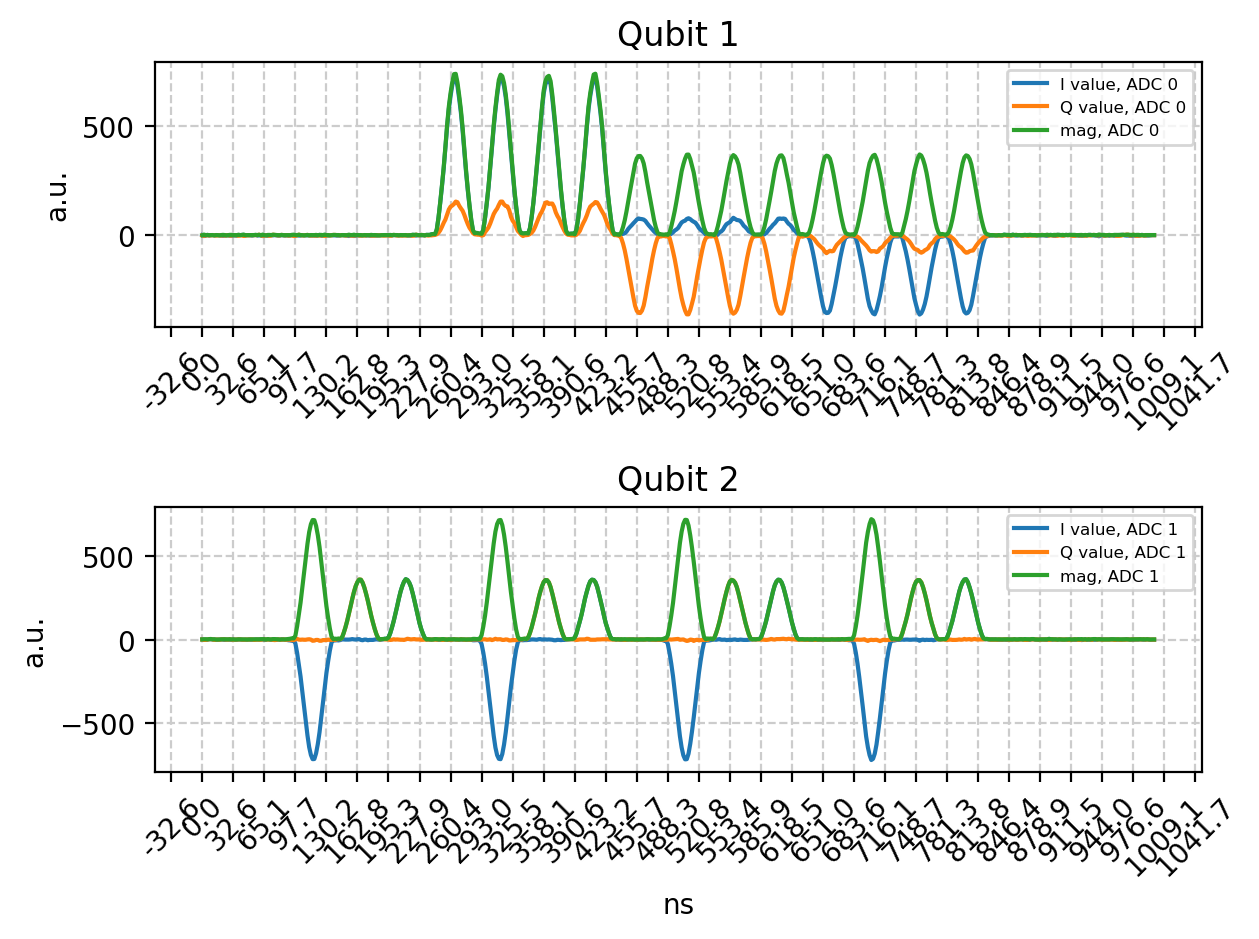

In [29]:
plot_2q(iq_lists)

## Active qubit control

Examples of active control in a qubit system incude active feedback, feedforward and active reset. For instance, feedback means that control decisions are being made based on the results of a readout. Feedback is directly important for mid-circuit measurement and state preparation, and ultimately, for quantum error correction. During quantum error correction, every error correction cycle, you measure the "syndrome" qubits and use that information to actively correct errors in the "data" qubits.

The QICK can perform active qubit control since it can execute conditional logic statements in real time. 

### Basic conditional logic statement

In [30]:
class LoopbackProgram(AveragerProgram):
    def initialize(self):
        cfg=self.cfg   

        # set the nyquist zone
        self.declare_gen(ch=cfg["res_ch"], nqz=1)

        #configure the readout lengths and downconversion frequencies
        self.declare_readout(ch=cfg["ro_ch"], length=self.cfg["readout_length"],
                             freq=self.cfg["pulse_freq"], gen_ch=cfg["res_ch"])

        freq=self.freq2reg(cfg["pulse_freq"], gen_ch=cfg["res_ch"], ro_ch=cfg["ro_ch"])  # convert frequency to dac frequency (ensuring it is an available adc frequency)
        self.set_pulse_registers(ch=cfg["res_ch"], style="const", freq=freq, phase=0, gain=cfg["pulse_gain"], 
                                 length=cfg["length"])
        
        # Set threshold
        self.regwi(0,1,self.cfg["threshold"])

        # Set value of number 
        self.regwi(0,2,self.cfg["number"])

        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):
        self.trigger(adcs=[self.cfg["ro_ch"]],adc_trig_offset=self.cfg["adc_trig_offset"])  # trigger the adc acquisition
        
        # Apply conditional logic statement: When number is smaller than threshold, skip over playing the pulse.
        self.condj(0,2,'<',1,'LABEL') 
        self.pulse(ch=self.cfg["res_ch"]) # play readout pulse
        self.label('LABEL')

        # control should wait until the readout is over
        self.wait_all() 

        self.sync_all(self.us2cycles(self.cfg["relax_delay"]))  # sync all channels

In [31]:
config={"res_ch":0, # --Fixed
        "ro_ch":0, # --Fixed
        "reps":1, # --Fixed
        "relax_delay":1.0, # --Fixed
        "res_phase":0, # --Fixed
        "length":20, # [Clock ticks]        
        "readout_length":200, # [Clock ticks]
        "pulse_gain":1000, # [DAC units]
        "pulse_freq": 100, # [MHz]
        "adc_trig_offset": soc.us2cycles(0.2,ro_ch=0),  # [Clock ticks] # 0.1 wokred
        "soft_avgs":100,
        ### New variables
        "number": 100,
        "threshold": 50
       }

prog =LoopbackProgram(soccfg, config)
(iq0,) = prog.acquire_decimated(soc, load_pulses=True, progress=True)

  0%|          | 0/100 [00:00<?, ?it/s]

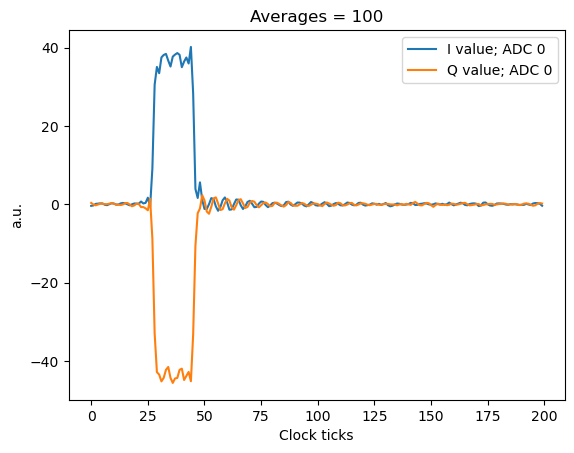

In [32]:
# Plot results.
plt.figure(1)
plt.plot(iq0[0], label="I value; ADC 0")
plt.plot(iq0[1], label="Q value; ADC 0")
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.title("Averages = " + str(config["soft_avgs"]))
plt.legend()

### When the value of <code> number </code> is below the threshold, the conditional statement is True so you don't see a loopback pulse.

In [33]:
config["number"]=10

prog =LoopbackProgram(soccfg, config)
(iq0,) = prog.acquire_decimated(soc, load_pulses=True, progress=True)

  0%|          | 0/100 [00:00<?, ?it/s]

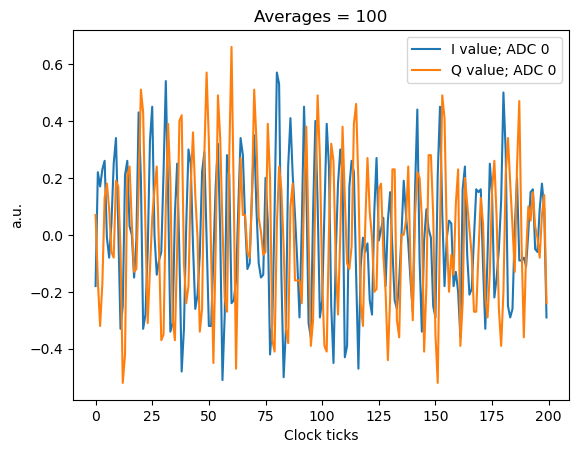

In [34]:
# Plot results.
plt.figure(1)
plt.plot(iq0[0], label="I value; ADC 0")
plt.plot(iq0[1], label="Q value; ADC 0")
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.title("Averages = " + str(config["soft_avgs"]))
plt.legend()

### While loop example

In [35]:
class LoopbackProgram(AveragerProgram):
    def initialize(self):
        cfg=self.cfg   

        # set the nyquist zone
        self.declare_gen(ch=cfg["res_ch"], nqz=1)

        #configure the readout lengths and downconversion frequencies
        self.declare_readout(ch=cfg["ro_ch"], length=self.cfg["readout_length"],
                             freq=self.cfg["pulse_freq"], gen_ch=cfg["res_ch"])

        self.freq=self.freq2reg(cfg["pulse_freq"], gen_ch=cfg["res_ch"], ro_ch=cfg["ro_ch"])  # convert frequency to dac frequency (ensuring it is an available adc frequency)
        self.set_pulse_registers(ch=cfg["res_ch"], style="const", freq=self.freq, phase=0, gain=cfg["pulse_gain"], 
                                 length=cfg["length"])
        
        self.page=self.ch_page(0) # Using registers on page 0     
        self.loop_reg = 4
        self.loop_end_reg = 5

        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):
        self.trigger(adcs=[self.cfg["ro_ch"]],adc_trig_offset=self.cfg["adc_trig_offset"])  # trigger the adc acquisition
        
        # Initialize loop
        self.regwi(self.page,self.loop_reg,0) # i=0

        # If detection, play pulse with larger gain
        self.label('LABEL1')
        self.pulse(ch=self.cfg["res_ch"]) # play readout pulse

        # Increment loop
        self.regwi(self.page,self.loop_end_reg,self.cfg["number"]) # loop ends when i<5
        self.mathi(self.page,self.loop_reg,self.loop_reg,'+',1) # i+=1
        self.condj(self.page,self.loop_reg,'<',self.loop_end_reg,'LABEL1')

        # If no detection, play pulse with smaller gain
        self.set_pulse_registers(ch=self.cfg["res_ch"], style="const", freq=self.freq, phase=0, gain=self.cfg["pulse_gain"]-100, 
                                 length=self.cfg["length"])
        self.pulse(ch=self.cfg["res_ch"]) # play readout pulse
          
        # control should wait until the readout is over
        self.wait_all() 
        self.sync_all(self.us2cycles(self.cfg["relax_delay"]))  # sync all channels
        

### While the loop counter is less than  <code> number </code> , the loopback pulse has a higher gain.

In [36]:
config={"res_ch":0, # --Fixed
        "ro_ch":0, # --Fixed
        "reps":1, # --Fixed
        "relax_delay":1.0, # --Fixed
        "res_phase":0, # --Fixed
        "length":20, # [Clock ticks]        
        "readout_length":200, # [Clock ticks]
        "pulse_gain":1000, # [DAC units]
        "pulse_freq": 100, # [MHz]
        "adc_trig_offset": soc.us2cycles(0.2,ro_ch=0),  # [Clock ticks] # 0.1 wokred
        "soft_avgs":100,
        ### New variables
        "number": 3,
       }

In [37]:
prog =LoopbackProgram(soccfg, config)
(iq0,) = prog.acquire_decimated(soc, progress=True)

  0%|          | 0/100 [00:00<?, ?it/s]

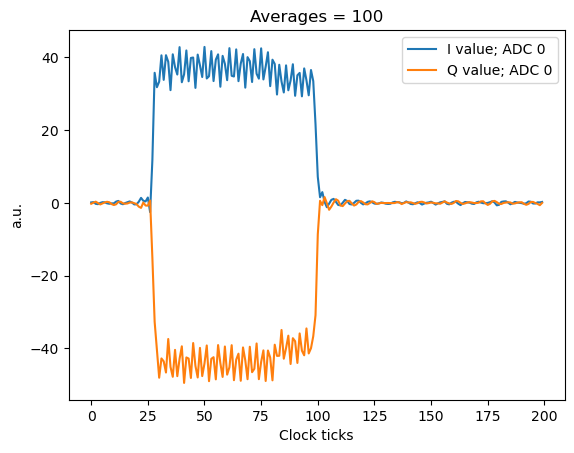

In [38]:
# Plot results.
plt.figure(1)
plt.plot(iq0[0], label="I value; ADC 0")
plt.plot(iq0[1], label="Q value; ADC 0")
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.title("Averages = " + str(config["soft_avgs"]))
plt.legend()

### Before moving on...
```diff
+ Can you explain what the I/Q quadratures are and how they relate to the qubit control signal? In the QubitReadout lab we will be looking at the I/Q quadratures associated with qubit readout signals.
```